In [46]:
import numpy as np
import pandas as pd

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 100)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# import and filter warnings
import warnings
warnings.filterwarnings("ignore")

### Download the CSV

In [2]:
! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-08 23:12:10--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.1’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.07s   

2025-10-08 23:12:11 (11.7 MB/s) - ‘car_fuel_efficiency.csv.1’ saved [874188/874188]



In [48]:
# read the car price data csv
car_fe_df = pd.read_csv("car_fuel_efficiency.csv")
# show the first 5 rows
car_fe_df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


## Preparing the dataset

In [49]:
# Use only the following columns:
# 'engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg'
base  = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = car_fe_df[base]

### EDA

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

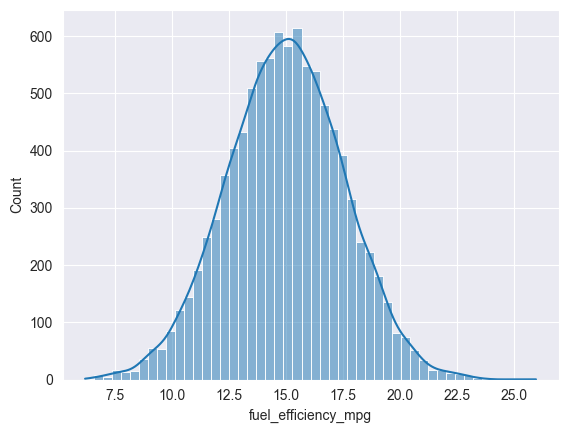

In [50]:
# Look at the fuel_efficiency_mpg variable. Does it have a long tail ?
sns.histplot(df["fuel_efficiency_mpg"], bins=50, kde=True)

**Observations**:
- The `fuel_efficiency_mpg` does not have significant long tail
- ’s a roughly symmetric, normal-like distribution.

### Question 1

In [51]:
# There's one column with missing values. What is it?
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

**Observations**
- Column `horsepower` has 708 missing values

### Question 2

In [52]:
# What's the median (50% percentile) for variable 'horsepower'?
df["horsepower"].median()

np.float64(149.0)

**Observations**
- 149.0 is the median for column 'horsepower' (including the missing values)

### Prepare and split the dataset

In [53]:
# Shuffle the dataset (the filtered one you created above), use seed 42.
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

# Split your data in train/val/test sets, with 60%/20%/20% distribution.
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

### Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only

In [54]:
# function to train linear regression model
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [55]:
# function to compute RMSE
def rmse(y, y_pred_local):
    se = (y - y_pred_local) ** 2
    mse = se.mean()
    return np.sqrt(mse)

#### Option 1 - fill missing values with 0

In [56]:
# fill missing values with 0 and drop the target variable fuel_efficiency_mpg from the training set
X_train_zeros = df_train.drop(columns=["fuel_efficiency_mpg"]).fillna(0).values

# train the model
w0, w = train_linear_regression(X_train_zeros, y_train)

# make predictions
y_pred = w0 + X_train_zeros.dot(w)

# compute RMSE for training set by filling missing values with 0
fill_zero_rmse = rmse(y_train, y_pred)

# Round the RMSE score to 2 decimal digits
fill_zero_rmse = round(fill_zero_rmse, 2)

# print the RMSE obtained on the training set by filling missing values with 0
print(f"Training Data RMSE (fill missing with 0): {fill_zero_rmse}")

# Use the validation dataset y_val to evaluate the models and compare the RMSE of each option
# drop the target variable fuel_efficiency_mpg from the validation set
X_val_zeros = df_val.drop(columns=["fuel_efficiency_mpg"]).fillna(0).values
y_val_pred = w0 + X_val_zeros.dot(w)
val_rmse_zeros = rmse(y_val, y_val_pred)

# Round the RMSE score to 2 decimal digits
val_rmse_zeros = round(val_rmse_zeros, 2)

# Round the RMSE scores to 2 decimal digits using round(score, 2)
print(f"Validation Data RMSE (fill missing with 0): {val_rmse_zeros}")


Training Data RMSE (fill missing with 0): 0.04
Validation Data RMSE (fill missing with 0): 0.04


#### Option 2 - fill missing values with the mean

In [57]:
# fill missing values with the mean of the training set
mean_horsepower = df_train["horsepower"].mean()
X_train_mean = df_train.drop(columns=["fuel_efficiency_mpg"]).fillna(mean_horsepower).values

# train the model
w0, w = train_linear_regression(X_train_mean, y_train)

# make predictions
y_pred = w0 + X_train_mean.dot(w)

# compute RMSE for training set by filling missing values with the mean
fill_mean_rmse = rmse(y_train, y_pred)

# Round the RMSE score to 2 decimal digits
fill_mean_rmse = round(fill_mean_rmse, 2)

# print the RMSE obtained on the training set by filling missing values with the mean
print(f"Training Data RMSE (fill missing with mean): {fill_mean_rmse}")

# For computing the mean, use the training only!
# Use the validation dataset to evaluate the models and compare the RMSE of each option.
# Round the RMSE scores to 2 decimal digits using round(score, 2)
X_val_mean = df_val.drop(columns=["fuel_efficiency_mpg"]).fillna(mean_horsepower).values
y_val_pred = w0 + X_val_mean.dot(w)
val_rmse_mean = rmse(y_val, y_val_pred)

# Round the RMSE score to 2 decimal digits
val_rmse_mean = round(val_rmse_mean, 2)

print(f"Validation Data RMSE (fill missing with mean): {val_rmse_mean}")

Training Data RMSE (fill missing with mean): 0.04
Validation Data RMSE (fill missing with mean): 0.04


**Observations:**
- Both methods to handle missing values give similar RMSE on the training set and the value is approx 0.04

### Question 4

In [58]:
# function to train regularized linear regression model
def train_linear_regression_reg(X, y, r_val):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r_val * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [60]:
# Now let's train a regularized linear regression.
# For this question, fill the NAs with 0.
# Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
# Use RMSE to evaluate the model on the validation dataset.
# Round the RMSE scores to 2 decimal digits.
# Which r gives the best RMSE?
X_train_zeros = df_train.drop(columns=["fuel_efficiency_mpg"]).fillna(0).values
X_val_zeros = df_val.drop(columns=["fuel_efficiency_mpg"]).fillna(0).values

# values of r to try
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
results = []

# For each value of r, train the model and evaluate on the validation set
for r in r_values:
    w0, w = train_linear_regression_reg(X_train_zeros, y_train, r)
    y_val_pred = w0 + X_val_zeros.dot(w)
    val_rmse = rmse(y_val, y_val_pred)
    val_rmse = round(val_rmse, 2)
    results.append((r, val_rmse))

# print the results
for r, score in results:
    print(f"r: {r}, Validation Data RMSE: {score}")

r: 0, Validation Data RMSE: 0.04
r: 0.01, Validation Data RMSE: 0.04
r: 0.1, Validation Data RMSE: 0.04
r: 1, Validation Data RMSE: 0.04
r: 5, Validation Data RMSE: 0.04
r: 10, Validation Data RMSE: 0.04
r: 100, Validation Data RMSE: 0.04


**Observations:**
- The 'RMSE' value remains at 0.04 for all values of 'r'
- So 0 is the smallest value for 'r' as it is the lowest regularization

### Question 5

In [61]:
# We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
# Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].

seeds = list(range(10))
rmse_scores = []

# For each seed, do the train/validation/test split with 60%/20%/20% distribution.
for seed in seeds:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]

    # Fill the missing values with 0 and train a model without regularization.
    X_train_zeros = df_train.drop(columns=["fuel_efficiency_mpg"]).fillna(0).values
    y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
    w0, w = train_linear_regression(X_train_zeros, y_train)

    # For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
    X_val_zeros = df_val.drop(columns=["fuel_efficiency_mpg"]).fillna(0).values
    y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
    y_val_pred = w0 + X_val_zeros.dot(w)
    val_rmse = rmse(y_val, y_val_pred)
    rmse_scores.append(val_rmse)

# What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
std_rmse = np.std(rmse_scores)

# Round the result to 3 decimal digits (round(std, 3))
std_rmse = round(std_rmse, 3)
print(f"Standard Deviation of RMSE scores: {std_rmse}")


Standard Deviation of RMSE scores: 0.001


### Question 6

In [68]:
# Split the dataset like previously, use seed 9.
# Combine train and validation datasets.
# Fill the missing values with 0 and train a model with r=0.001.
# What's the RMSE on the test dataset?
seed = 9
idx = np.arange(n)
np.random.shuffle(idx)
np.random.seed(seed)

n_train_val = n_train + n_val
df_train = df.iloc[idx[:n_train_val]]
df_test = df.iloc[idx[n_train_val:]]

X_train_zeros = df_train.drop(columns=["fuel_efficiency_mpg"]).fillna(0).values
y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
w0, w = train_linear_regression_reg(X_train_zeros, y_train, 0.001)

X_test_zeros = df_test.drop(columns=["fuel_efficiency_mpg"]).fillna(0).values
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

y_test_pred = w0 + X_test_zeros.dot(w)
test_rmse = rmse(y_test, y_test_pred)

# Round the result to 4 decimal digits (round(rmse, 2))]
test_rmse = round(test_rmse, 2)
print(f"Test Data RMSE: {test_rmse}")

Test Data RMSE: 0.04


**Note :** closest value of 0.15 selected to the obtained value of 0.04